In [1]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
from statsmodels.stats.proportion import proportions_ztest

from sklearn.metrics import auc
import xgboost as xgb


from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/uplift-modeling/criteo-uplift-v2.1.csv


In [2]:
df = pd.read_csv('/kaggle/input/uplift-modeling/criteo-uplift-v2.1.csv')

# Introduction

<i>This is my first attempt at exploring uplift modelling, any comments, feedback, or suggestions would be greatly appreciated.</i>

Uplift modelling is an important area of research which aims to estimate the causal impact of some treatment on an individual's behaviour. The model predicts the difference between a customer’s behaviour when there is a treatment and when there is no treatment. In the digital advertising industry, for example, this treatment could be exposure to different ads and uplift modelling could then be used to direct marketing efforts towards users for whom this intervention is most efficient. This is important because some customers will naturally respond to treatments in different ways:

* <b>Persuadables</b> will always respond POSITIVE to the marketing communication. They are going to purchase ONLY if treated.
* <b>Do-Not-Disturbs </b> (a.k.a. Sleeping-dogs) have a strong negative response to a marketing communication. They are going to purchase if NOT treated and will NOT purchase IF treated.
* <b>Lost Causes </b> will NOT purchase the product NO MATTER they are contacted or not. The marketing budget in this case is also wasted because it has no effect.
* <b>Sure Things </b> will purchase ANYWAY no matter they are contacted or not. There is no motivation to spend the budget because it also has no effect.

The goal of uplift modelling, therefore, is to identify the “persuadables”, not waste efforts on “sure things” and “lost causes”, and avoid bothering “sleeping dogs”, or those who would react negatively to the treatment, if they exist. Uplift modelling has found application in many domains including marketing, medical treatments and political campaigns.

## Dataset

Now that we know the goal of uplift modeling, how do we get there? A typical starting point for building an uplift model is a dataset from a randomized, controlled experiment: we need a representative sample of all different kinds of customers in both a treatment group, as well as a control group that didn’t receive the treatment. If the proportion of customers making a purchase is significantly higher in the treatment group than the control group, we know that the promotion is “working” since it encourages a purchase on average across all customers. This is called the average treatment effect (ATE). Quantifying the ATE is the typical outcome of an A/B test.

I use an anonymised dataset published by The Criteo AI Lab which is available [here][1]. The dataset is constructed from an incrementality tests, a particular randomized trial procedure where an advertiser prevents a random part of the population from being targeted by advertising. It consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 labels (visits and conversions). 

A more detailed description of the features is shown below:
* f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)
* treatment: treatment group (1 = treated, 0 = control)
* conversion: whether a conversion occured for this user (binary, label)
* visit: whether a visit occured for this user (binary, label)
* exposure: treatment effect, whether the user has been effectively exposed (binary)

In real data, the features may correspond to such things as customer purchase history, demographics, and other quantities a data scientist may engineer with the hypothesis that they would be useful in modeling uplift.

Let’s load the data and briefly explore it.

[1]: https://www.kaggle.com/arashnic/uplift-modeling/

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [4]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [5]:
print('Total number of samples: {}'.format(len(df)))

Total number of samples: 13979592


In [6]:
df['treatment'].value_counts(normalize = True)

1    0.85
0    0.15
Name: treatment, dtype: float64

The dataset is largely imbalanced - around 85% of users were treated while only 15% were in the control group.

# Basic Eda

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 <a list of 16 Text major ticklabel objects>)

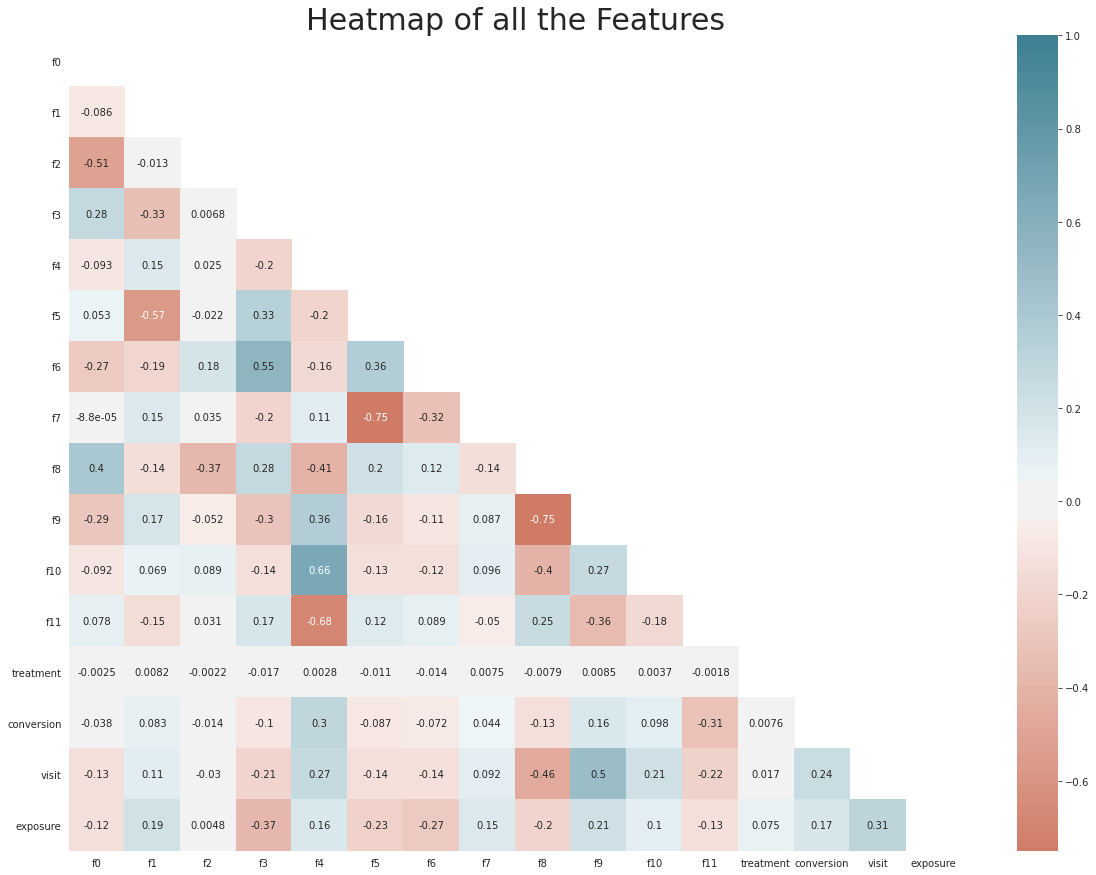

In [7]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (20,15))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, )
plt.title("Heatmap of all the Features", fontsize = 30)
plt.yticks(rotation=0)

In [8]:
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4)))
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4)))
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4)))

Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


Again, the 2 binary labels (visits and conversions) are both highly imbalanced but how do these metrics compare between the control and the treatment groups?

In [9]:
vis_results_df = df.groupby('treatment').agg({'visit':['mean', 'sum', 'count']})
vis_results_df

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.048543  576824  11882655

In [10]:
con_results_df = df.groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})
con_results_df

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.003089  36711  11882655

In [11]:
print(f'Difference in clickthrough rate between control and treatment: {np.round(df.groupby("treatment")["visit"].mean()[1] - df.groupby("treatment")["visit"].mean()[0], 4)}')
print(f'Difference in conversion between control and treatment: {np.round(df.groupby("treatment")["conversion"].mean()[1] - df.groupby("treatment")["conversion"].mean()[0], 4)}')

Difference in clickthrough rate between control and treatment: 0.0103
Difference in conversion between control and treatment: 0.0012


More users visit in the treatment (4.9%) than the control group (3.8%), indicating the treatment is effective at encouraging users to visit: the ATE is positive and is about 1%. This increase in visits also yields a higher conversion rate in the treatment group (0.31%) compared to the control group (0.19%). 

As the difference is not so large, a significance test is conducted.

In [12]:
proportions_ztest(count=vis_results_df[('visit', 'sum')],
                  nobs=vis_results_df[('visit', 'count')])[1]

0.0

In [13]:
proportions_ztest(count=con_results_df[('conversion', 'sum')],
                  nobs=con_results_df[('conversion', 'count')])[1]

7.30826328583868e-179

The p-value is <0.05 for both, so we know the ATE is significant - which is the typical starting point for uplift modeling.

It is worth pointing out that there is another variable called 'exposure' which indicates whether a treatment was properly exposed to the user. This is important because a user that is treated might still carry out an desired action (clicking, purchasing etc..) without actually being influenced by the treatment. It would be interesting to see whether there is a big differences in outcomes depending on whether a user was effectively exposed.

First of all, how many users in the treatment group were exposed?

In [14]:
df[df['treatment']==1]['exposure'].value_counts(normalize = True)

0    0.963963
1    0.036037
Name: exposure, dtype: float64

Only 3.6% or 1 out of every 28 users in our treatment group were effectively exposed to the treatment, suggesting the treatment is very ineffective at capturing the attention of the users. 

How does the number of users that visit and convert differ between treated users that were exposed, and those that were not?

In [15]:
vis_exp_results_df = df[df['treatment']==1].groupby('exposure').agg({'visit':['mean', 'sum', 'count']})
vis_exp_results_df

visit                  
              mean     sum     count
exposure                            
0         0.034861  399314  11454443
1         0.414538  177510    428212

In [16]:
con_exp_results_df = df[df['treatment']==1].groupby('exposure').agg({'conversion':['mean', 'sum', 'count']})
con_exp_results_df

conversion                 
               mean    sum     count
exposure                            
0          0.001194  13680  11454443
1          0.053784  23031    428212

In [17]:
proportions_ztest(count=vis_exp_results_df[('visit', 'sum')],
                  nobs=vis_exp_results_df[('visit', 'count')])[1]

0.0

In [18]:
proportions_ztest(count=con_exp_results_df[('conversion', 'sum')],
                  nobs=con_exp_results_df[('conversion', 'count')])[1]

0.0

There is a substantially higher clickthrough rate for treated users that were exposed (41%) than treated users that were not (3.5%). Similar results were found for conversion, with 5.3% of exposed users converting compared to only 0.12% of treated users that were not . These results, together with the p-value's (<0.5) suggest the intervention is having a significant impact, but is not being exposed to enough people. Lets see if theres any effect not being exposed has on the treatment group.

In [19]:
df[df['exposure']==0].groupby('treatment').agg({'visit':['mean', 'sum', 'count']})

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.034861  399314  11454443

In [20]:
df[df['exposure']==0].groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.001194  13680  11454443

Incredibly, the percentage of users that convert and visit in the treatment actually declines if they are not exposed, meaning the ATE is negative. In a real life scenario, this would need to be addressed.


# Resampling
In thise case, I will be focusing my uplift models on the incremental number of visits due to the number of users that do not convert. Before proceeding with modelling, it is worth considering any imbalance in the dataset and addressing it accordingly.

Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

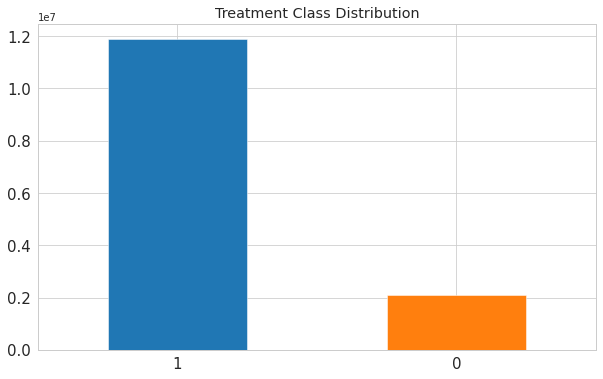

In [21]:
fig = plt.figure(figsize = (10,6))
target_count = df['treatment'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

By seeing the distributions we can have an idea how skewed the target variable is - most of the users were in the treatment group. The problem is that many approaches uplift models assume the treatment group and the control group have a balanced distribution, which needs not hold in practice. In this case we may reweight, or resample, the training datasets such that the assumption becomes valid. According to Jaśkowski and Jaroszewicz (2012) resampling the treatment distribution can affect the learning algorithm and result in information loss, however, as long as the algorithm does a reasonably good job at modeling the conditional class distributions, the results will still be meaningful. As our dataset consists of 13M rows, we can be fairly confident any resampled dataset will contain enough instances to provide meaningful results.

Before proceeding with the random undersampling we have to separate the orginal dataframe so that the undersampling is only done on the training dataset. Why? for testing purposes, we want to test our models on a dataset with real life class distributions.

In [22]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])

In [23]:
# Random Undersampling (finding the majority class and undersampling it)
def random_under(df:pd.DataFrame, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [24]:
train = random_under(train, 'treatment')

Class 0: 1677550
Class 1: 1677550
Proportion: 1 : 1


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

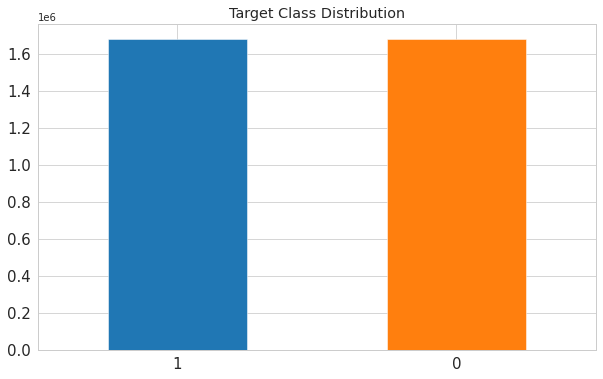

In [25]:
fig = plt.figure(figsize = (10,6))
new_target_count = train['treatment'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Target Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

As can be seen, the new training dataset has a total of 3,355,100 instances with 50% in the treatment and 50% in the control groups.

# Uplift Modelling
The Uplift model used in this notebook is the Generalized Weighed Uplift (LGWUM) (Kane et al., 2014). LGWUM is one of several methods available for Uplift Modeling, and uses an approach to Uplift Modelling better known as Class Variable Transformation. LGWUM assumes that positive uplift lies in treating treatment-group responders (TR) and control-group non-responders (CN), whilst avoiding treatment-group non-responders (TN) and control-group responders (CR). This is visually shown as:

𝑈𝑝𝑙𝑖𝑓𝑡 𝐿𝐺𝑊𝑈𝑀 = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)

In [26]:
# Function to declare Target Class

def target_class(df, treatment, target):
    
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0),'target_class'] = 1 
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0),'target_class'] = 2 
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0),'target_class'] = 3 
    return df

In [27]:
train = target_class(train.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')
test = target_class(test.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')

In [28]:
X_train = train.drop(['visit','target_class'],axis=1)
y_train = train['target_class']
X_test = test.drop(['visit','target_class'],axis=1)
y_test = test['target_class']

The model works by predicting the probability that a given customer belongs to each  classes. The uplift can then be calculated as the differences between these probabilities.

In [29]:
def uplift_model(X_train,
                 X_test,
                 y_train,
                 y_test,
                 treatment_feature):

    result = pd.DataFrame(X_test).copy()    
    uplift_model = xgb.XGBClassifier().fit(X_train.drop(treatment_feature, axis=1), y_train)
    
    uplift_proba = uplift_model.predict_proba(X_test.drop(treatment_feature, axis=1))
    
    result['p_cn'] = uplift_proba[:,0] 
    result['p_cr'] = uplift_proba[:,1] 
    result['p_tn'] = uplift_proba[:,2] 
    result['p_tr'] = uplift_proba[:,3]
    
    result['uplift_score'] = result.eval('\
    p_cn/(p_cn + p_cr) \
    + p_tr/(p_tn + p_tr) \
    - p_tn/(p_tn + p_tr) \
    - p_cr/(p_cn + p_cr)')  

    # Put the result 
    result['target_class'] = y_test
    
    return result

In [30]:
result = uplift_model(X_train, X_test, y_train, y_test, 'treatment')
result.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,p_cn,p_cr,p_tn,p_tr,uplift_score,target_class
6304619,21.890358,10.059654,8.214383,4.679882,10.280525,4.115453,-4.595460,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0.501398,0.000227,0.497943,0.000432,0.000828,0
4045638,15.995929,10.059654,8.214383,0.973841,10.280525,4.115453,-7.301017,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.497313,0.001595,0.498510,0.002583,0.003917,2
5767216,19.111923,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0.502048,0.000478,0.496681,0.000794,0.001291,0
9668584,12.870404,10.059654,8.979246,-1.025575,10.280525,4.115453,-16.175537,4.833815,3.902645,13.190056,5.300375,-0.168679,1,0.426351,0.009061,0.541204,0.023385,0.041219,2
830405,21.992620,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.501502,0.000234,0.498045,0.000220,-0.000050,2


Text(0, 0.5, 'Number of observations in validation set')

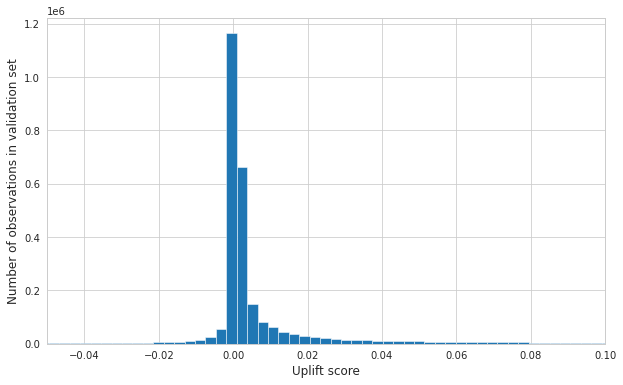

In [31]:
plt.figure(figsize = (10,6))
plt.xlim(-.05, .1)
plt.hist(result.uplift_score, bins=1000, color=['#2077B4'])
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')

The distribution of uplift is mostly positive, which makes sense since we know from our analysis that the treatment encourages visits on average. However some instances have negative uplift, meaning the treatment actually discourages individuals from visiting ('sleeping dogs'). Going back to our previous analyses, this could be the individuals who were not properly exposed to the treatment, which we found to decrease clickthrough & conversion.

# Model evaluation

Metrics for evaluating uplift are more complex than typical metrics used in supervised learning, such as the ROC AUC. This is because it is not possible to observe both the control and the treatment outcomes for a given individual at the same time, which makes it dicult to find a loss measure. One way to measure uplift is using a Qini curve (Radcliffe, 2007), which shows the cumulative number of the incremental positive outcomes or uplift as a function of the number of customers treated. A more performant model can distinguish individuals with positive outcomes from individuals with negative outcomes, yielding a larger separation between the curve and the diagonal, which would represent a random targeting strategy.

In [32]:
def qini_rank(uplift): 
    # Function to Rank the data by the uplift score
    ranked = pd.DataFrame({'ranked uplift':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    ranked['ranked uplift'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='ranked uplift').reset_index(drop=True)
    return ranked

def qini_eval(ranked):
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['ranked uplift'] * uplift_model['uplift'].iloc[-1],5)
    
    uplift_model['Number_of_exposed_customers'] = np.arange(len(uplift_model))+1
    uplift_model['visits_gained'] = uplift_model.uplift*len(uplift_model)
    
    # Add q0
    q0 = pd.DataFrame({'ranked uplift':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='ranked uplift').reset_index(drop = True)
    return merged, uplift_model

def uplift_curve(uplift_model):
    plt.figure(figsize = (10,6))
    # plot the data
    ax = uplift_model['visits_gained'].plot(color=['#2077B4'])
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Number of customers treated')
    plt.ylabel('Incremental visits')
    plt.grid(b=True, which='major')
    return ax

def qini_plot(merged:pd.DataFrame, uplift_model:pd.DataFrame):
    gain_x = uplift_model['ranked uplift']
    gain_y = uplift_model.uplift
    qini = auc(gain_x, gain_y)
    # plot the data
    plt.figure(figsize = (10,6))
    mpl.rcParams['font.size'] = 8
    qini = auc(gain_x, gain_y)

    ax = plt.plot(gain_x, gain_y, color= '#2077B4',
        label='Normalized Uplift Model, Qini Score: {}'.format(round(qini,2)))
    
    plt.plot([0, gain_x.max()], [0, gain_y.max()],
        '--', color='tab:orange',
        label='Random Treatment')
    plt.legend()
    plt.xlabel('Porportion Targeted')
    plt.ylabel('Uplift')
    plt.grid(b=True, which='major')

    return ax

def plot_uplift(result:pd.DataFrame):
    # Function to plot the uplift curve
    ranked = qini_rank(result)
    merged, uplift_model = qini_eval(ranked)
    ax1 = uplift_curve(uplift_model)
    
    return ax1

def plot_qini(result:pd.DataFrame):
    # Function to plot the qini curve
    ranked = qini_rank(result)
    merged, uplift_model = qini_eval(ranked)
    ax2 = qini_plot(merged, uplift_model)
    
    return ax2 

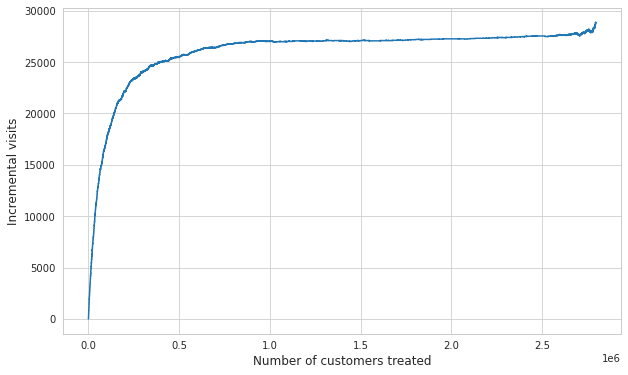

In [33]:
plot_uplift(result)

If we offer the treatment to every customer (2,500,000), we’ll increase the number of visitors by 30,000. However we can achieve a gain of 26,000 customers, about 86% of the maximum possible, by only offering treatment to the top 20% of customers. 
One advantage of the uplift curve, however, is that similar to the ROC curve, we can calculate an area under the curve, with the interpretation that larger area indicates a better performing model: we would like to be able to gain as many customers as possible, by targeting a few as possible. 

Before calculating an AUC, it is better to normalize the data. As shown, the gain curve has units of customers on both the x- and y-axes which can be good for visualizing things in real-world quantities however it makes comparing different models very difficult. We can fix this by scaling the curve so that the axes are between 0 and 1. 

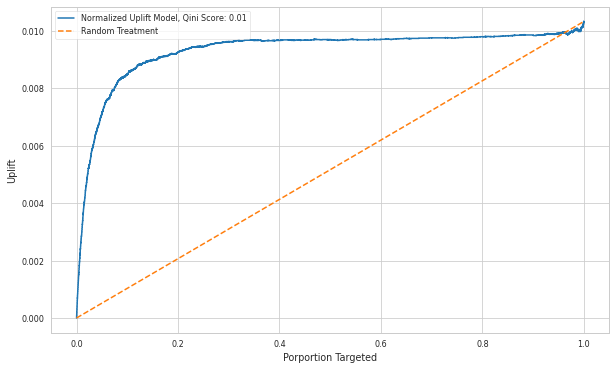

In [34]:
plot_qini(result)

While the model appears to be able to distinguish positive from negative outcomes as shown by its steep initial slope, the Qini-score is only 0.01, suggesting the total incremental positive outcomes from the treatment is low and that actually there is little difference between this treatment and a random targeting strategy.

It is worth considering what impact a user being properly exposed has on their incremental outcomes. This will be explored by calling the pre-defined functions from above while changing the treatment classes to 'exposure'.

Class 0: 13551380
Class 1: 428212
Proportion: 32 : 1


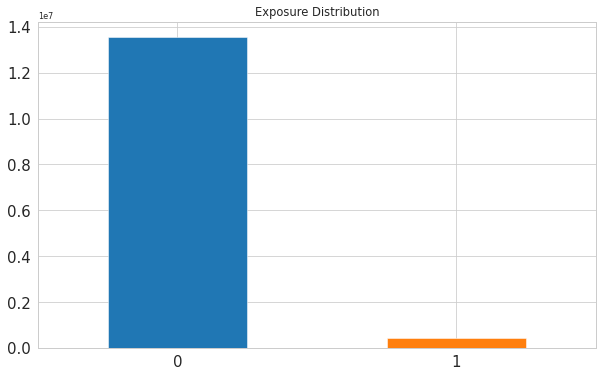

In [35]:
plt.figure(figsize = (10,6))
target_count = df['exposure'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[0] / target_count[1])), ': 1')
target_count.plot(kind='bar', title='Exposure Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 
plt.show()

Much like in the previous example, the treatment class is highly imbalanced, with roughly 1 in every 32 users being exposed to the treatment. 

In [36]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['exposure'])

In [37]:
train = random_under(train, 'exposure')

Class 0: 342570
Class 1: 342570
Proportion: 1 : 1


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

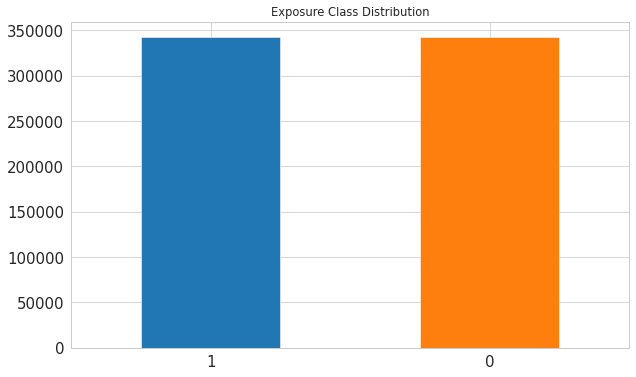

In [38]:
plt.figure(figsize = (10,6))
new_target_count = train['exposure'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Exposure Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

In [39]:
train = target_class(train.drop(columns = ['conversion', 'treatment']), 'exposure', 'visit')
test = target_class(test.drop(columns = ['conversion', 'treatment']), 'exposure', 'visit')

In [40]:
X_train = train.drop(['visit','target_class'],axis=1)
y_train = train['target_class']
X_test = test.drop(['visit','target_class'],axis=1)
y_test = test['target_class']

In [41]:
result = uplift_model(X_train, X_test, y_train, y_test, 'exposure')

Text(0, 0.5, 'Number of observations in validation set')

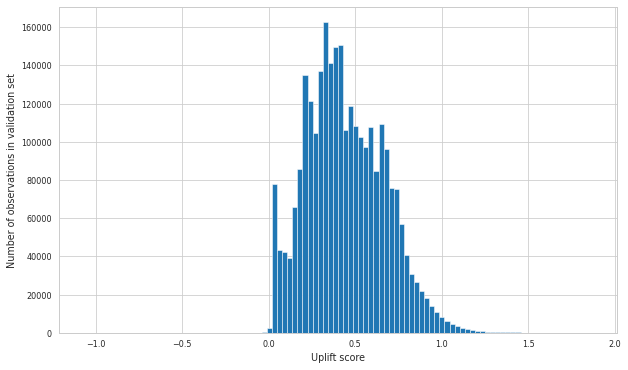

In [42]:
plt.figure(figsize = (10,6))
plt.hist(result.uplift_score, bins=100, color=['#2077B4'])
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')

The distribution of uplift is almost entirely positive, meaning the treatment almost always encourages individuals to visit when they are properly exposed, and almost never discouraging them.

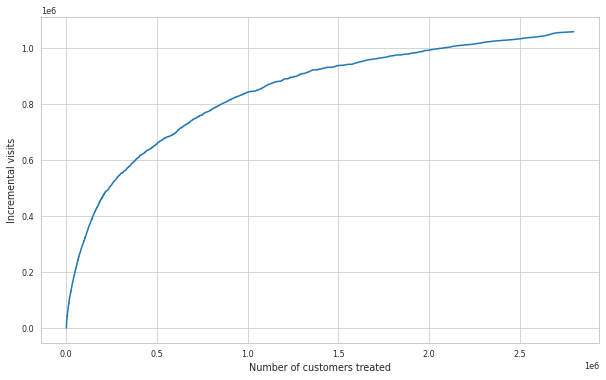

In [43]:
plot_uplift(result)

As can be seen, when users are properly exposed to the treatment, the incremental positive outcomes or uplift is much higher. If we offer the treatment to every customer, we’ll increase the number of visitors by 1,060,000. However we can achieve a gain of 620,000 customers, about 58% of the maximum possible, by only offering treatment to the top 20% of customers. Given the different magnitude of customers, in order to compare this model to our previous one, we must once again normalize our results. 

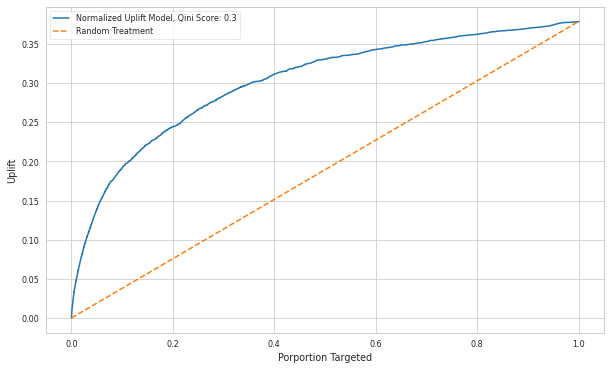

In [44]:
plot_qini(result)

As can be seen, the Qini-score is roughly x29 better than the previous model suggesting the cumulative number of the incremental positive outcomes is much larger providing users are effectively exposed. 

# Conclusion

The goal of uplift modeling is to create predictive models of the individual treatment effect. Such models allow data scientists to segment populations into groups that are more likely to respond to treatment, and those that are less so. In this example, the effect of properly exposing users to the treatment  is shown to significantly increase the incremental outcomes compared to the normal treatment group. As can be seen the evaluation of uplift models is not as straightforward as that of supervised classification or regression models because it requires separate consideration, and comparison, of treatment and control groups. However, open source Python packages ([CausalML](http://https://causalml.readthedocs.io/en/latest/), [Pylift](http://https://pylift.readthedocs.io/), [Scikit-Uplift](http://https://scikit-uplift.readthedocs.io/en/latest/)), have been created to facilitate uplift model development and evaluation. 


<b> Some resources that helped me and I recommend taking a look at if you're interested in finding out more: </b>

Gubela, Robin & Bequé, Artem & Gebert, Fabian & Lessmann, Stefan. (2019). Conversion Uplift in E-Commerce: A Systematic Benchmark of Modeling Strategies. International Journal of Information Technology & Decision Making. 18. 10.1142/S0219622019500172.  

Gutierrez, P., & Gérardy, J. Y. (2017, July). Causal Inference and Uplift Modelling: A Review of the Literature. In International Conference on Predictive Applications and APIs (pp. 1-13). 

Cheng, L., Leung, A. C. S., & Ozawa, S. (Eds.). (2018). Neural Information Processing. Lecture Notes in Computer Science. doi:10.1007/978-3-030-04221-9  

https://www.steveklosterman.com/uplift-modeling/

This notebook adapts some of the functions provided in this notebook:
https://www.kaggle.com/arashnic/uplift-modeling



